# Predicting Social-Media Influence in the NBA

In [9]:
import numpy as np

import pandas as pd

import statsmodels.api as sm

import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

import seaborn as sns

color = sns.color_palette()

%matplotlib inline

# データの読み込み

In [10]:
nba=pd.read_csv('./dataset/socialpowernba/data/nba_2017_br.csv')

attendance_df = pd.read_csv("./dataset/socialpowernba/data/nba_2017_attendance.csv")

endorsement_df = pd.read_csv("./dataset/socialpowernba/data/nba_2017_endorsements.csv")

valuations_df = pd.read_csv("./dataset/socialpowernba/data/nba_2017_team_valuations.csv")

salary_df = pd.read_csv("./dataset/socialpowernba/data/nba_2017_salary.csv")

pie_df = pd.read_csv("./dataset/socialpowernba/data/nba_2017_pie.csv")

plus_minus_df = pd.read_csv("./dataset/socialpowernba/data/nba_2017_real_plus_minus.csv")

br_stats_df = pd.read_csv("./dataset/socialpowernba/data/nba_2017_br.csv")

elo_df = pd.read_csv("./dataset/socialpowernba/data/nba_2017_elo.csv")

# 結合

In [11]:
attendance_df.head()

,TEAM,GMS,PCT,TOTAL_MILLIONS,AVG_MILLIONS
0,Chicago Bulls,41,104,0.888882,0.021680
1,Dallas Mavericks,41,103,0.811366,0.019789
2,Sacramento Kings,41,101,0.721928,0.017608
3,Miami Heat,41,100,0.805400,0.019643
4,Toronto Raptors,41,100,0.813050,0.019830


In [12]:
valuations_df.head()

,TEAM,VALUE_MILLIONS
0,New York Knicks,3300.0
1,Los Angeles Lakers,3000.0
2,Golden State Warriors,2600.0
3,Chicago Bulls,2500.0
4,Boston Celtics,2200.0


In [13]:
attendance__valuation_df=attendance_df.merge(valuations_df,how='inner',on='TEAM')

In [14]:
attendance__valuation_df.head()

,TEAM,GMS,PCT,TOTAL_MILLIONS,AVG_MILLIONS,VALUE_MILLIONS
0,Chicago Bulls,41,104,0.888882,0.021680,2500.0
1,Dallas Mavericks,41,103,0.811366,0.019789,1450.0
2,Sacramento Kings,41,101,0.721928,0.017608,1075.0
3,Miami Heat,41,100,0.805400,0.019643,1350.0
4,Toronto Raptors,41,100,0.813050,0.019830,1125.0


# 可視化

## チームの資産価値と、集客に相関があるかを確認する

/Users/hiroaki/.pyenv/versions/3.6.5/envs/NBA/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/hiroaki/.pyenv/versions/3.6.5/envs/NBA/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


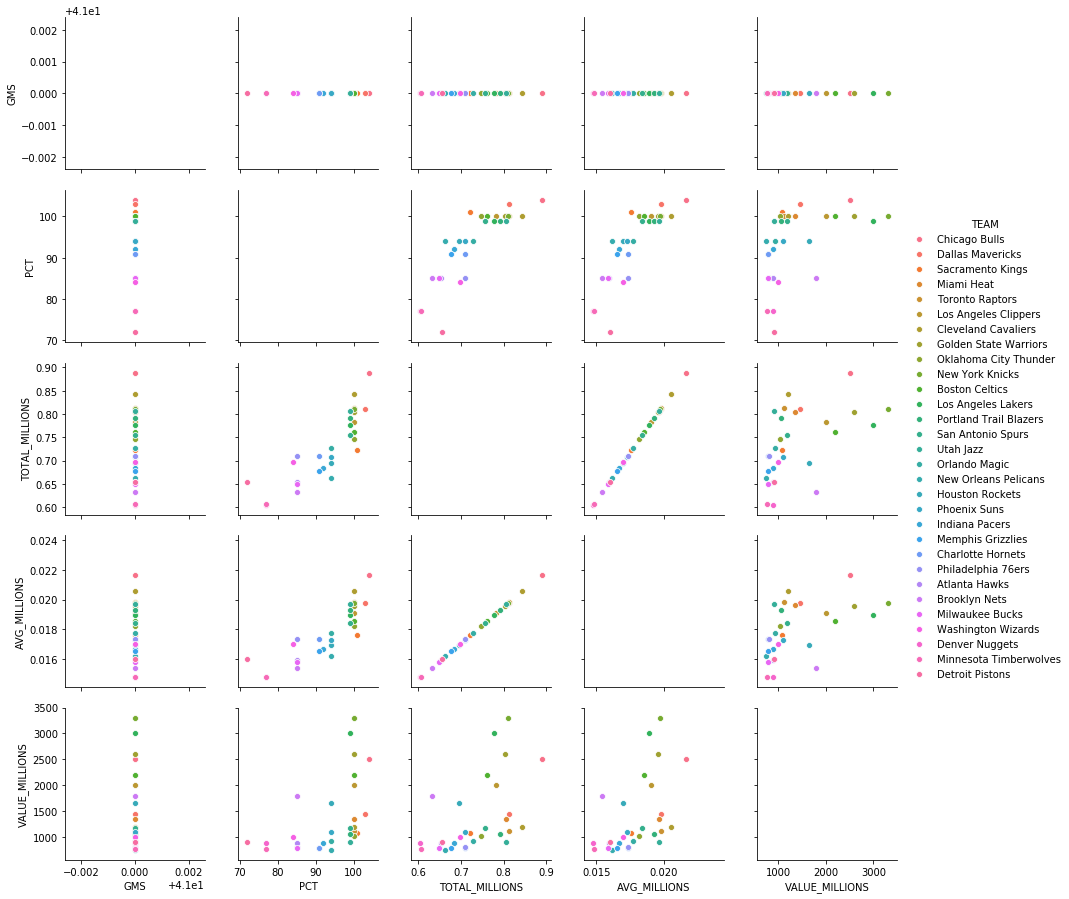

In [15]:
from IPython.core.display import display,HTML

display(HTML(
    """
    <style>.

container{ width:100% !important; }</style>
    """
))

sns.pairplot(attendance__valuation_df,hue='TEAM')

## それぞれの特徴量同士の相関係数

In [17]:
corr=attendance__valuation_df.corr()

corr.head()

,GMS,PCT,TOTAL_MILLIONS,AVG_MILLIONS,VALUE_MILLIONS
GMS,NaN,NaN,NaN,NaN,NaN
PCT,NaN,1.000000,0.850839,0.85085,0.476644
TOTAL_MILLIONS,NaN,0.850839,1.000000,1.00000,0.530697
AVG_MILLIONS,NaN,0.850850,1.000000,1.00000,0.530730
VALUE_MILLIONS,NaN,0.476644,0.530697,0.53073,1.000000


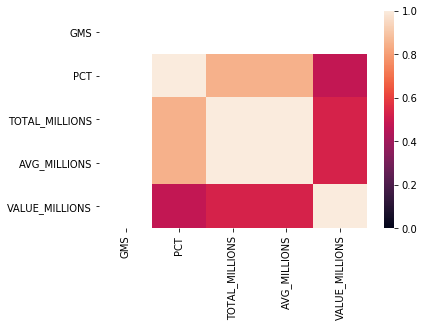

In [35]:
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,vmin=0,vmax=1)

##　チームごとの金額に応じた、平均の観客導入数

In [23]:
valuations=attendance__valuation_df.pivot('TEAM','TOTAL_MILLIONS','VALUE_MILLIONS')

valuations.head()

TOTAL_MILLIONS,0.605585,0.6072029999999999,0.632608,0.6489520000000001,0.654306,0.655141,0.663099,0.6773140000000001,0.684578,0.6959029999999999,...,0.782609,0.792029,0.8034359999999999,0.8054,0.806605,0.8107409999999999,0.811366,0.81305,0.843042,0.888882
TEAM,,,,,,,,,,,,,,,,,,,,,
Atlanta Hawks,NaN,NaN,NaN,NaN,885.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Boston Celtics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brooklyn Nets,NaN,NaN,1800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Charlotte Hornets,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chicago Bulls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500.0


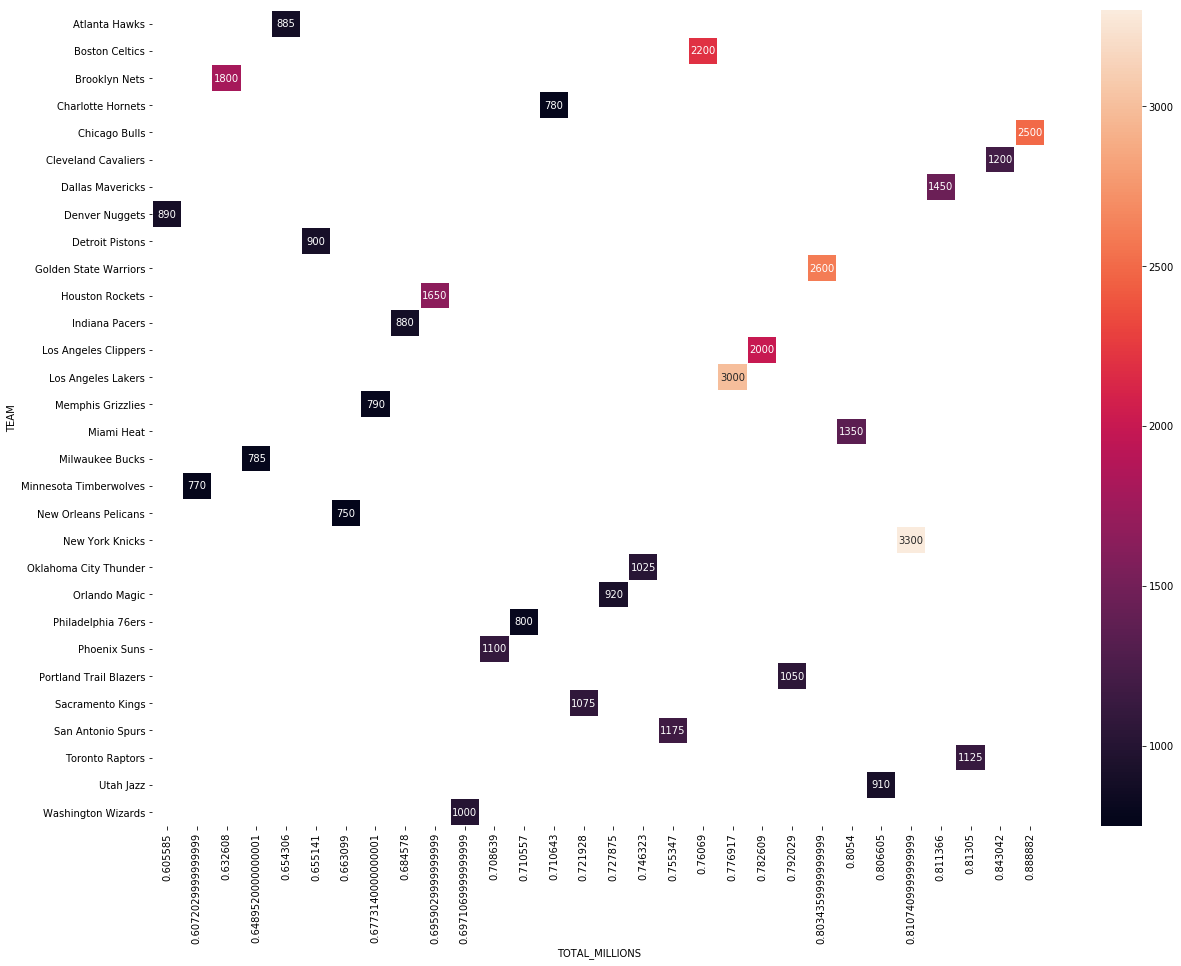

In [27]:
fig,ax=plt.subplots(figsize=(20,15))

sns.heatmap(ax=ax,annot=True,fmt='g',data=valuations,linewidths=.5)

# 資産と観客動員数の回帰モデルを生成する

In [32]:
results=smf.ols(
'VALUE_MILLIONS~TOTAL_MILLIONS',
data=attendance__valuation_df).fit()

# モデルを評価
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         VALUE_MILLIONS   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     10.98
Date:                Thu, 19 Jul 2018   Prob (F-statistic):            0.00255
Time:                        20:55:18   Log-Likelihood:                -234.04
No. Observations:                  30   AIC:                             472.1
Df Residuals:                      28   BIC:                             474.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2408.0191   1141.332     -2.

## 残差のplot

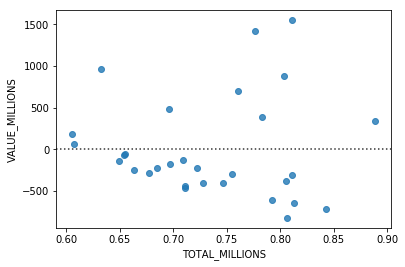

In [34]:
sns.residplot(y='VALUE_MILLIONS',x='TOTAL_MILLIONS',data=attendance__valuation_df)




仮に理想的なモデルの場合、残差均等性により、残差は完全にランダムに散らばるが、そうでない場合、モデルで表現できていない何らかの法則性があると考えるのが妥当
https://bellcurve.jp/statistics/course/9704.html

## 不完全なモデルのplot

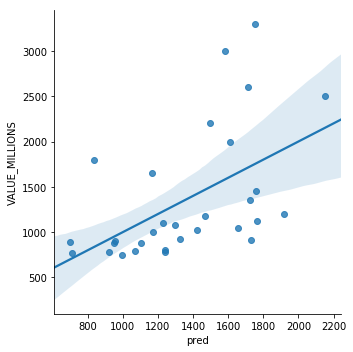

In [40]:
attendance__valuation_pred_df=attendance__valuation_df.copy()

attendance__valuation_pred_df['pred']=results.predict()

sns.lmplot(x='pred',y='VALUE_MILLIONS',data=attendance__valuation_pred_df)
